Before running the program, please unzip the file"corpus",

Upload the files to the root directory of your google drive.  
These are conull files needed to run the model.
Basically the different language I test are:
English,  

In [5]:
# Our standard imports for math and basic methodology
import numpy as np
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import seaborn as sns

!pip install conllu
from torch.utils.data import Dataset, DataLoader
from conllu import parse
from conllu import parse_incr

import random
from random import shuffle
random.seed(1)

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

# Remember to unzip and upload the files in the zipped file ,
# Authorize access to your google drive and change the directory to root directory.
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive"
os.chdir(path)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Inherit the dataset class in pytorch to process our data.

We process the path of file and get the data we want to put into the model.

Two choices of data augmentation are offered: synonym replacement and random deletion. 

In [0]:
class POSDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, conllu_file_path, word2idx=None, tag2idx=None, idx2word=None, idx2tag=None, training=False, eng_aug=False):
        self.data_file = open(conllu_file_path, "r", encoding="utf-8")
        self.x = []
        self.y = []
        self.stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
                'ours', 'ourselves', 'you', 'your', 'yours', 
                'yourself', 'yourselves', 'he', 'him', 'his', 
                'himself', 'she', 'her', 'hers', 'herself', 
                'it', 'its', 'itself', 'they', 'them', 'their', 
                'theirs', 'themselves', 'what', 'which', 'who', 
                'whom', 'this', 'that', 'these', 'those', 'am', 
                'is', 'are', 'was', 'were', 'be', 'been', 'being', 
                'have', 'has', 'had', 'having', 'do', 'does', 'did',
                'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
                'because', 'as', 'until', 'while', 'of', 'at', 
                'by', 'for', 'with', 'about', 'against', 'between',
                'into', 'through', 'during', 'before', 'after', 
                'above', 'below', 'to', 'from', 'up', 'down', 'in',
                'out', 'on', 'off', 'over', 'under', 'again', 
                'further', 'then', 'once', 'here', 'there', 'when', 
                'where', 'why', 'how', 'all', 'any', 'both', 'each', 
                'few', 'more', 'most', 'other', 'some', 'such', 'no', 
                'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
                'very', 's', 't', 'can', 'will', 'just', 'don', 
                'should', 'now', ''] 
        
        for tokenlist in parse_incr(self.data_file): 
            a = []
            b = []
            if len(tokenlist) >= 3:
                for token in tokenlist:
                    a.append(token['form']) 
                    b.append(token['upostag'])
                self.x.append(a)
                self.y.append(b)
        
        if eng_aug: 
            if eng_aug == 'sn_replacement':
                for i in range(len(self.x)):
                    self.x[i] = self.synonym_replacement(self.x[i])

            if eng_aug == 'rd_deletion':
                X_dele = []
                y_dele = []
                for sentences, labels in zip(self.x, self.y):
                    new_sentences, new_labels = self.random_deletion(sentences, labels)
                    X_dele.append(new_sentences)
                    y_dele.append(new_labels)
                self.x = X_dele
                self.y = y_dele
        
        if training == True:  # if it's a training set data, we will split them into test set and training set for training set testing
            self.x_fin, self.x_test, self.y_fin, self.y_test = train_test_split(self.x, self.y, test_size=0.1, random_state=0)
        else:
            self.x_fin = self.x
            self.y_fin = self.y 
        
    def __len__(self):
        return len(self.x_fin)

    def __getitem__(self, idx): 
        x = self.x_fin[idx]
        y = self.y_fin[idx]
        
        return x, y
    
    def get_testset(self): # this allows the mean accuracy function we will use later to get the test_set
        return self.x_test, self.y_test

    def get_graph(self): # this will print out the distribution of dataset based on sentence length
        l = np.asarray([len(x) for x in self.x], dtype=np.int)
        plt.figure()
        x = np.unique(l)
        plt.bar(x, [np.sum(l==e) for e in x])
        plt.xlabel("Sentence length")
        plt.ylabel("# sentences")
        plt.show()
        
    def data_peek(self): # this allows you too look at first 5 sentences and tags
        a, b = self.x[:5], self.y[:5]
        print(a)
        print(b)
        
    def len_data(self): # this tells you how many sentences are in the data
        return len(self.x)
    # This gets a list of synonym of an english word.
    def get_synonyms(self, word): 
        synonyms = set()
        for syn in wordnet.synsets(word): 
            for l in syn.lemmas(): 
                synonym = l.name().replace("_", " ").replace("-", " ").lower()
                synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
                synonyms.add(synonym) 
        if word in synonyms:
            synonyms.remove(word)
        
        word1 = word.split(' ')
        deletion = []
        for word in synonyms:
            if len(word1) != len(word.split(' ')):
                deletion.append(word)
        for word in deletion:
            synonyms.remove(word)
        
        return list(synonyms)
    # This replaces up to 3 words in a sentence with their synonyms.
    def synonym_replacement(self, words, n=3): 
        new_words = words.copy()
        random_word_list = list(set([word for word in words if word not in self.stop_words]))
        random.shuffle(random_word_list)
        num_replaced = 0
        for random_word in random_word_list:
            synonyms = self.get_synonyms(random_word)
            if len(synonyms) >= 1:
                synonym = random.choice(list(synonyms))
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
            if num_replaced >= n: #only replace up to n words
                break

        #this is stupid but we need it, trust me
        sentence = ' '.join(new_words)
        new_words = sentence.split(' ')
        return new_words

    # This randomly deletes a word in a sentence with possibility of 0.7.
    def random_deletion(self, words, labels, p=0.7): 
        if len(words) == 3:
            return words, labels
        origin = len(words)
        new_words = []
        new_labels = []
        del_list = []
        for i, word in enumerate(words):
            if origin - len(del_list) > 3: # we will never trim the sentence into lower than length 3
                r = random.uniform(0,1)
                if r > p:
                    del_list.append(i)
                    
        for i in range(len(words)):
            if i not in del_list:
                new_words.append(words[i])
                new_labels.append(labels[i])
                
        return new_words, new_labels

## LSTM based tagger as a Class
with bi-directionary choice offered.

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, word_embedding_dim, lstm_hidden_dim, word2idx, tag2idx, bidirectional, num_layers):
        """An LSTM based tagger

        word_embedding_dim
          The dimensionality of the word embedding
        lstm_hidden_dim
          The dimensionality of the ...
        vocabulary_size
          The size of the vocabulary (i.e. the number of unique words in the word embedding)
        tagset_size
        """

        tagset_size = len(tag2idx)-1
        vocabulary_size = len(word2idx)
        self.word2idx = word2idx

        super(LSTMTagger, self).__init__()                                  # We need to initialise the class we are inheriting from
        self.lstm_hidden_dim = lstm_hidden_dim                             # This simply stores the parameter
        self.vocabulary_size = vocabulary_size
        self.tagset_size = tagset_size
        self._word_embeddings = nn.Embedding(num_embeddings=vocabulary_size,     # Creates the vector space for the input words
                                             embedding_dim=word_embedding_dim, 
                                             padding_idx=self.word2idx['<PAD>'])
        self._lstm = nn.LSTM(input_size=word_embedding_dim,                 # The LSTM takes an embedded sentence as input, and outputs 
                             hidden_size=lstm_hidden_dim,                   # vectors with dimensionality lstm_hidden_dim.
                             batch_first=True,
                             bidirectional=bidirectional,
                             num_layers=num_layers)

        self._hidden2tags = nn.Linear(lstm_hidden_dim, tagset_size)         # The linear layer maps from the RNN output space to tag space

    def forward(self, padded_sentences):
        """The forward pass through the network"""

        batch_size, max_sentence_length = padded_sentences.size()

        sentence_lengths = list()
        for i in range(batch_size):
            for j in range(max_sentence_length, 1, -1):
                if padded_sentences[i, j-1] != self.word2idx['<PAD>']:
                    sentence_lengths.append(j)
                    break
        sentence_lengths = torch.LongTensor(sentence_lengths)
        embedded_sentences = self._word_embeddings(padded_sentences)                            # Sentences encoded as integers are mapped to vectors    

        X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths,
                                              batch_first=True, enforce_sorted = False)
        lstm_out, _ = self._lstm(X)
        X, _ = nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        tag_space = self._hidden2tags(X)     
        # The output from the LSTM layer is flattened and passed to the fully 
                                                                            # connected layer.
        tag_scores = F.log_softmax(tag_space, dim=1)                        # Softmax is applied to normalise the outputs

        return tag_scores.view(batch_size, max_sentence_length, self.tagset_size)

## GRU based tagger as a class
dropout and bi-directionary can be added.

In [0]:
class GRUTagger(nn.Module):
    
    def __init__(self, word_embedding_dim, gru_hidden_dim, word2idx, tag2idx, bidirectional, num_layers, dropout):
        tagset_size = len(tag2idx)-1
        vocabulary_size = len(word2idx)
        self.word2idx = word2idx        

        super().__init__()                                  # We need to initialise the class we are inheriting from
        self.gru_hidden_dim = gru_hidden_dim                             # This simply stores the parameter
        self.vocabulary_size = vocabulary_size
        self.tagset_size = tagset_size
        self._word_embeddings = nn.Embedding(num_embeddings=vocabulary_size,     # Creates the vector space for the input words
                                             embedding_dim=word_embedding_dim, 
                                             padding_idx=self.word2idx['<PAD>'])
        self._gru = nn.GRU(input_size=word_embedding_dim,                 # The LSTM takes an embedded sentence as input, and outputs 
                             hidden_size=gru_hidden_dim,                   # vectors with dimensionality lstm_hidden_dim.
                             batch_first=True, 
                             bidirectional=bidirectional,
                             num_layers=num_layers,
                             dropout=dropout)

        self._hidden2tags = nn.Linear(gru_hidden_dim, tagset_size)         # The linear layer maps from the RNN output space to tag space

    def forward(self, padded_sentences):
        """The forward pass through the network"""

        batch_size, max_sentence_length = padded_sentences.size()

        sentence_lengths = list()
        for i in range(batch_size):
            for j in range(max_sentence_length, 1, -1):
                if padded_sentences[i, j-1] != self.word2idx['<PAD>']:
                    sentence_lengths.append(j)
                    break
        sentence_lengths = torch.LongTensor(sentence_lengths)
        embedded_sentences = self._word_embeddings(padded_sentences)                            # Sentences encoded as integers are mapped to vectors    

        X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths,
                                              batch_first=True, enforce_sorted = False)
        gru_out, _ = self._gru(X)
        X, _ = nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        tag_space = self._hidden2tags(X)     
        # The output from the LSTM layer is flattened and passed to the fully 
                                                                            # connected layer.
        tag_scores = F.log_softmax(tag_space, dim=1)                        # Softmax is applied to normalise the outputs

        return tag_scores.view(batch_size, max_sentence_length, self.tagset_size)

## Whole Pipeline as a Class

This pipeline combines the data loading, data preprocessing, model loading, model running and presenting the data.


The input is the filepath of the data and whether we should apply english augmentation.

In [0]:
from torch.utils import data
class pipeline():
    
    def __init__(self, filepath, eng_aug=False): 
        self.filepath = filepath
        self.training_set = POSDataset(filepath, training = True, eng_aug=eng_aug) 
        self.create_idx() 
    
    # draw the graph about the sentence length.
    def trainingset_info(self):
        self.training_set.get_graph() 
        
    def create_idx(self): # creating idx, word, tag trasition dictionary
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.tag2idx = dict()
        for sentence, tags in zip(self.training_set.x_fin, self.training_set.y_fin):
            for word in sentence:
                word = word.lower()
                if word not in self.word2idx:    # The 'in' operator is fast for dictionaries
                    self.word2idx[word] = len(self.word2idx)
            for tag in tags:
                if tag not in self.tag2idx:
                    self.tag2idx[tag] = len(self.tag2idx)
                    
        self.tag2idx['<PAD>'] = len(self.tag2idx)

        # Creates lists for converting indeces to tags or words
        self.idx2word = [None]*len(self.word2idx)
        for word, idx in self.word2idx.items():
            self.idx2word[idx] = word
        self.idx2tag = [None]*len(self.tag2idx)
        for tag, idx in self.tag2idx.items():
            self.idx2tag[idx] = tag

    # we create and choose the model hyperparameter.
    def create_model(self, WORD_EMBEDDING_DIM=32, HIDDEN_DIM=32, model_type='lstm', bidirectional=False, num_layers=1, dropout=0):
        if model_type == 'lstm':
            self.model = LSTMTagger(word_embedding_dim=WORD_EMBEDDING_DIM, 
                               lstm_hidden_dim=HIDDEN_DIM, 
                               word2idx=self.word2idx,
                               tag2idx=self.tag2idx,
                               bidirectional=bidirectional,
                               num_layers=num_layers
                               )
            return self.model
        
        elif model_type == 'gru':
            self.model = GRUTagger(word_embedding_dim=WORD_EMBEDDING_DIM, 
                               gru_hidden_dim=HIDDEN_DIM, 
                               word2idx=self.word2idx,
                               tag2idx=self.tag2idx,
                               bidirectional=bidirectional,
                               num_layers=num_layers,
                               dropout=dropout
                               )
            return self.model

    def pad_data(self, sentences, labels):     # padding data
        assert len(sentences)==len(labels)
        assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
        max_len = np.max([len(sentence) for sentence in sentences]) # Find out how much to pad
        padded_sentences  = list()
        padded_labels  = list()
        for sentence, tags in zip(sentences, labels):               # Loop over the data
            padded_sentence = [word.lower() if word.lower() in self.word2idx else '<UNK>' for word in sentence]  # Sentence, uses the <UNK> symbol for unknown words
            padded_tags = [tag for tag in tags]                       # Tags
            while len(padded_sentence) < max_len:                     # Adds padding to the sequences 
                padded_sentence.append('<PAD>')
                padded_tags.append('<PAD>')
            padded_sentences.append(padded_sentence)                  # Append the processed sample to the output
            padded_labels.append(padded_tags)
        return padded_sentences, padded_labels

    def encode_data(self, padded_sentences, padded_labels): # encoding data
        encoded_sentences = list()
        for padded_sentence in padded_sentences:
            encoded_sentences.append([self.word2idx[word] for word in padded_sentence])
        encoded_labels = list()
        for padded_tags in padded_labels:
            encoded_labels.append([self.tag2idx[tag] for tag in padded_tags])
        return torch.LongTensor(encoded_sentences), torch.LongTensor(encoded_labels)        
        
    def transform(self, xy): # use encoding data and padding data together for model training
        xout, yout = self.encode_data(*self.pad_data(xy[0], xy[1]))
        return xout, yout
    
    # after creating the model, we choose the optimizing parameters to train the model.
    # you can choose the number of epoch, optimizer, learning rate and weight decay.
    def training(self, batch_size=2000, n_epoch=10, optimizer='adam', lr=0.05, report=False, weight_decay=0): 
        if self.model: 
            
            loss_function = nn.NLLLoss(ignore_index=self.tag2idx['<PAD>'])
            training_generator = data.DataLoader(self.training_set, batch_size, shuffle=True) 

            # We give the optimiser the parameters to work with and a learning rate
            if optimizer == 'adam':
                optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
            elif optimizer == 'sgd':
                optimizer = optim.SGD(self.model.parameters(), lr=lr, weight_decay=weight_decay)
            

            x_train = []
            y_train = []

            for x, y in map(self.transform, training_generator):
                x_train.append(x)
                y_train.append(y)    

            self.loss_for_plotting = list()
            start_t = time.time()
            for epoch in range(n_epoch):
                for inputs, targets in zip(x_train, y_train):    # Now for looping over the training data
                    self.model.zero_grad()                                       # Reset gradients
                    tag_scores = self.model(inputs)                              # Forward pass
                    tag_scores = tag_scores.view(-1, self.model.tagset_size)     # Resize to get tag probabilities along a separate dimension
                                                                        # but flatten all the different sentences
                    targets = targets.view(-1)                              # Flatten y
                    loss = loss_function(tag_scores, targets)               # Get loss
                    loss.backward()                                         # Backpropagate the error
                    optimizer.step()                                        # Run the optimizer to change the weights w.r.t the loss

                    self.loss_for_plotting.append(loss.item())                   # Save the loss for plotting
                if report:
                    print("Epoch %i: loss=%.3f, time=%.1fs" % (epoch, loss, time.time()-start_t))        
        else:
            print("Please use create_model() method first")

    def plotting(self):  # look at the plot of loss over epochs
        if self.loss_for_plotting:
            plt.figure()
            plt.title("Plot for the (hopefully) decreasing loss over epochs")
            plt.plot(self.loss_for_plotting, '.-')
            plt.xlabel("Batch")
            plt.ylabel("Loss")
            plt.show()
        else:
            print("Please use training() method first")

    def tag_mean_accuracy(self, y, y_hat): 
        accuracy = list()
        for u, v in zip(y, y_hat):
            accuracy.append(np.sum([e1==e2 for e1, e2 in zip(u, v)])/len(u))
        return np.mean(accuracy), np.std(accuracy)

    def mean_acc(self, report=False): # get the accuracy of the model, if report is true, it will print the result
        X_test, y_test = self.training_set.get_testset() 
        with torch.no_grad():
            inputs, _ = self.encode_data(*self.pad_data(X_test, y_test))
            tag_scores = self.model(inputs)
            tag_idx = np.asarray(np.argmax(tag_scores.numpy(), axis=2), dtype=np.int)
            y_hat = list()
            for i in range(tag_scores.shape[0]):
                padding_mask = inputs[i, :] != self.word2idx['<PAD>']
                y_hat.append([self.idx2tag[e] for e in tag_idx[i, padding_mask]])
        accuracy, sigma = self.tag_mean_accuracy(y_test, y_hat)
        if report:
            print("Mean accuracy: %.1f%% [std %.1f%%]" % (100*accuracy, 100*sigma))
        return accuracy, sigma
    
    def get_data_length(self): # see how many sentences there are
        return self.training_set.len_data()

## Pipeline

We try 15 langauges in our model and we categorize them according to the language
family they belong to. We have 4 for uravic, 5 for germanic, 5 for slavic and 
one Chinese.
We hope to see that for language in the similar linguistic family, they might 
have similar structure and would show resemblence in model with same complexity.
But we are proved wrong. And the size of data proves to be a bigger impact 
on performance.


The below model is based on bi-directional GRU, with 36 embedding/hidden dimension and 1 layer.

In [10]:
# prepare some langauge data

# Germanic
swedish = "sv_lines-ud-train.conllu"
norwegian = "no_bokmaal-ud-train.conllu"
dutch = "nl_alpino-ud-train.conllu"
german = "de_gsd-ud-train.conllu"
danish = "da_ddt-ud-train.conllu"

# Slavic
russian = "ru_gsd-ud-train.conllu"
ukrainian = "uk_iu-ud-train.conllu"
belarusian = "be_hse-ud-train.conllu"
polish = "pl_lfg-ud-train.conllu"
czech = "cs_cac-ud-train.conllu"

# Uravic
north_sami = "sme_giella-ud-test.conllu"
hungarian = "hu_szeged-ud-test.conllu"
Estonian = "et_ewt-ud-test.conllu"
Finish = "fi_ftb-ud-dev.conllu"

# Chinese
chinese = "zh_gsd-ud-train.conllu"

# prepapre a dictionary to put into pandas dataframe.
language_list = [swedish, norwegian, dutch, german, danish, russian, ukrainian, belarusian, polish, czech, north_sami, hungarian, Estonian, Finish, chinese]
language_name = ['Swedish', 'Norwegian', 'Dutch', 'german', 'Danish', 'Russian', 'Ukrainian', 'Belarusian', 'Polish', 'Czech', 'North_Sami', 'Hungarian', 'Estonian', 'Finish', 'Chinese']
datapile = dict()
datapile['Language'] = []
datapile['Accuracy'] = []
datapile['Std'] = []
datapile['Number of Sentences'] = []

# chosse the gru model
def language_test(language_path, language_name):
    language_gru = pipeline(language_path)
    # create a model with parameter as below
    language_gru.create_model(WORD_EMBEDDING_DIM=36, HIDDEN_DIM=36, model_type='gru', bidirectional=True, num_layers=1, dropout=0)
    # train over the data with the optimizing option as below
    language_gru.training(batch_size=2000, n_epoch=4, optimizer='adam', lr=0.05, weight_decay=0)
    # get the accuracy, mean and number of sentences.
    accuracy, sigma = language_gru.mean_acc()
    datapile['Accuracy'].append(100*accuracy)
    datapile['Language'].append(language_name)
    datapile['Std'].append(100*sigma)
    datapile['Number of Sentences'].append(language_gru.get_data_length())

# pring the length of the langauge and testing result.    
for i in range(len(language_list)):
    print('Now processing:', language_name[i])
    language_test(language_list[i], language_name[i])

languages = pd.DataFrame(datapile)
print()
print('Germanic Languages')
print(languages[0:5])
print()
print('Slavic Languages')
print(languages[5:10])
print()
print('Roman Languages')
print(languages[10:14])
print()
print('Chinese')
print(languages[14:])

Now processing: Swedish
Now processing: Norwegian
Now processing: Dutch
Now processing: german
Now processing: Danish
Now processing: Russian
Now processing: Ukrainian
Now processing: Belarusian
Now processing: Polish
Now processing: Czech
Now processing: North_Sami
Now processing: Hungarian
Now processing: Estonian
Now processing: Finish
Now processing: Chinese

Germanic Languages
    Language   Accuracy        Std  Number of Sentences
0    Swedish  58.448377  15.764788                 3152
1  Norwegian  78.146350  13.000835                15172
2      Dutch  78.937507  12.712439                12183
3     german  71.300016  10.843572                13800
4     Danish  58.492869  12.831729                 4222

Slavic Languages
     Language   Accuracy        Std  Number of Sentences
5     Russian  42.559083  12.888112                 3848
6   Ukrainian  57.955214  14.854894                 5379
7  Belarusian  39.757755  16.734061                  319
8      Polish  76.307774  17.2881

Test on English data set to see whether below works:


Data Augmentation, Dropout, Weight Decay

We examine random deletion, synonym replacement(simple data augmentation on nlp), dropout and weight decay's effect on our data. The data augmentation involves two approaches. 

1. random deletion works in our model.
2. synonym hurt the accuracy.
These two are intended to improve the robutness of the model while dataset are 
small.
3. weight decay show no obvious effect. It works as a L2 regularization in updating the parameter.
4. dropout hurts the accuracy. It is designed to improve model's robutness and 
prevemt over-fitting by randomly deleting some neuron in an extra dropout layer.

In [11]:
english = "en_ewt-ud-train.conllu"

def english_test(language_path, eng_aug, dropout, weight_decay, layers):
    language_gru = pipeline(language_path, eng_aug=eng_aug)
    language_gru.create_model(WORD_EMBEDDING_DIM=36, HIDDEN_DIM=36, model_type='gru', bidirectional=True, num_layers=layers, dropout=dropout)
    language_gru.training(batch_size=2000, n_epoch=4, optimizer='adam', lr=0.05, weight_decay=weight_decay)
    accuracy, sigma = language_gru.mean_acc(report=True)

print("No data augmentation, no dropout, no weight decay")
english_test(english, eng_aug=False, dropout= 0, weight_decay=0, layers=1)
print()
print('Use random deletion, no dropout, no weight decay')
english_test(english, eng_aug='rd_deletion', dropout= 0, weight_decay=0, layers=1)
print()
print('Use synonyms replacement, no dropout, no weight decay')
english_test(english, eng_aug='sn_replacement', dropout= 0, weight_decay=0, layers=1)
print()
print('No data augmentation, dropout = 0.5, no weight decay')
english_test(english, eng_aug=False, dropout= 0.5, weight_decay=0, layers=2)
print()
print('No data augmentation, no dropout, weight decay = 0.0001')
english_test(english, eng_aug=False, dropout= 0, weight_decay=0.0001, layers=1)


No data augmentation, no dropout, no weight decay
Mean accuracy: 77.4% [std 13.7%]

Use random deletion, no dropout, no weight decay
Mean accuracy: 77.7% [std 15.7%]

Use synonyms replacement, no dropout, no weight decay
Mean accuracy: 73.1% [std 14.0%]

No data augmentation, dropout = 0.5, no weight decay
Mean accuracy: 77.4% [std 13.9%]

No data augmentation, no dropout, weight decay = 0.0001
Mean accuracy: 76.1% [std 14.4%]


# Model complexity
We take 6 languages and produce result through our pipeline. 
We increase embedding, hidden dimension, number of layer and test how accuracy 
changes on different languages.

Embedding Dimension/ Hidden Dimension: from 36 to 116 (gap 20)
Number of layers : from 1 to 16 (gap 5)


Please note that below code will take quite a long time to run.

The result is visualized in the next cell.

Arabic Training Data Info:


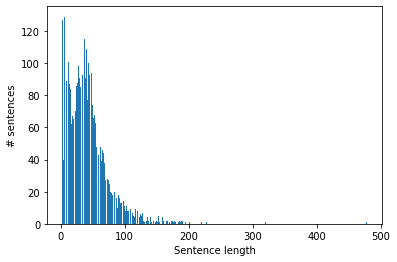

Traditional Chinese Training Data Info:


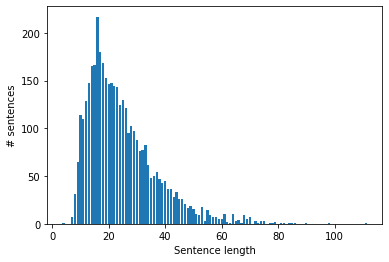

Finnish Training Data Info:


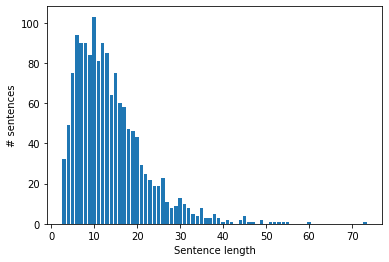

English Training Data Info:


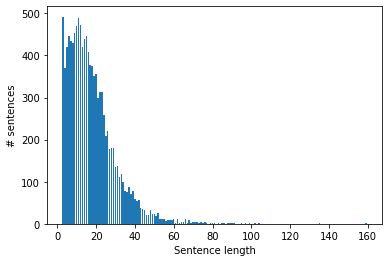

Hindi Training Data Info:


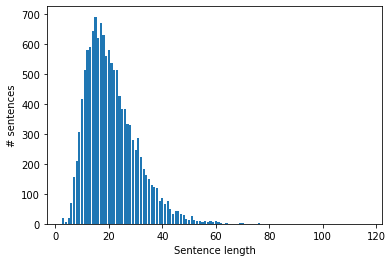

Persian Training Data Info:


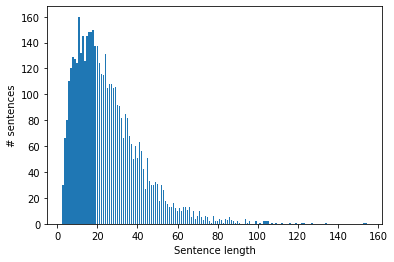

In [13]:
arabic = "ar_padt-ud-train.conllu"
traditional_chinese = "zh_gsd-ud-train.conllu"
finnish = "fi_tdt-ud-test.conllu"
english = "en_ewt-ud-train.conllu"
hindi = "hi_hdtb-ud-train.conllu"
persian = "fa_seraji-ud-train.conllu"

dimdata = dict()
lydata = dict()
dimdata['Dimensions'] = []
dimdata['Language'] = []
dimdata['Accuracy'] = []

lydata['Layers'] = []
lydata['Language'] = []
lydata['Accuracy'] = []

np.arange(36, 117, 20)
np.arange(1, 12, 5)

def model_complexity_test(language_path, language_name):
    global dimdata, lydata
    language_lstm = pipeline(language_path)
    print(language_name, "Training Data Info:")
    language_lstm.trainingset_info()
    dim = list()
    ly = list()
    for n in range(0, 5):
        num = 36 + n*20
        language_lstm.create_model(WORD_EMBEDDING_DIM=num, HIDDEN_DIM=num, model_type='lstm', bidirectional=False, num_layers=1)
        language_lstm.training(batch_size=2000, n_epoch=4, optimizer='adam', lr=0.05, weight_decay=0)
        accuracy, sigma = language_lstm.mean_acc()
        dim.append(100*accuracy)
        dimdata['Dimensions'].append(num)
    dim = np.array(dim)
    name_list = np.array([language_name]*len(dim))
    dimdata['Accuracy'].extend(dim)
    dimdata['Language'].extend(name_list)
    
    for n in range(0, 4):
        num = 1 + 5*n
        language_lstm.create_model(WORD_EMBEDDING_DIM=36, HIDDEN_DIM=36, model_type='lstm', bidirectional=False, num_layers=num)
        language_lstm.training(batch_size=2000, n_epoch=4, optimizer='adam', lr=0.05, weight_decay=0)
        accuracy, sigma = language_lstm.mean_acc()
        ly.append(100*accuracy)
        lydata['Layers'].append(num)
    ly = np.array(ly)
    name_list = np.array([language_name]*len(ly))
    lydata['Accuracy'].extend(ly)
    lydata['Language'].extend(name_list)
    '''
    for i in range(len(wd)):
        print('word embed', str(dim[i]))
    
    for i in range(len(hd)):
        print('layer', str(ly[i]))
    '''
model_complexity_test(arabic, 'Arabic')
model_complexity_test(traditional_chinese, 'Traditional Chinese')
model_complexity_test(finnish, 'Finnish')
model_complexity_test(english, 'English')
model_complexity_test(hindi, 'Hindi')
model_complexity_test(persian, 'Persian')

Model complexity and language


Below is the visualization performance of model on different languages.

We can conclude that Persian, Finish, Traditional Chinese and Hindi are very sensitive to model complexity.

Chinese performance better as the model has more and dimensions, while going downwards when the number of layers goes up.

Arabic share similar trend with Chinese.

Hindi and Persian flunctuates as the number of layers and dimensions increase, despite maintaining an upward trend.


Finish goes through up and downs as the complexity changes but it still on 
an upward trend, reaching an overall lowest accuracy.

Probably it still requires more dimensions and layers.

English keeps a high accuracy level despite the change of model complexity.

This might have something to do with the structure of languages, but we might need
further comparison studies on language structures.

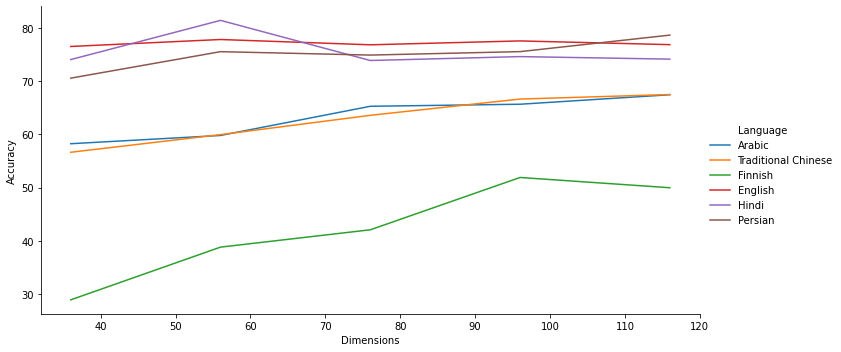

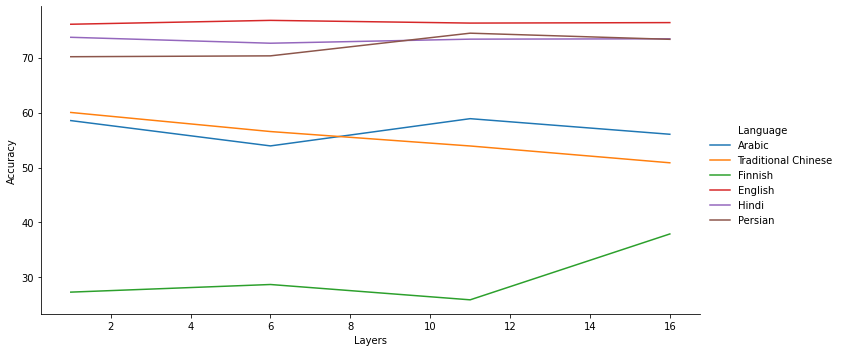

In [14]:
# store the dimension and layer data in pandas dataframe and draw the plot.

df = pd.DataFrame(dimdata)
bf = pd.DataFrame(lydata)


# prepare plot
ax = sns.relplot(x='Dimensions', y='Accuracy', data=df,
                 hue='Language', kind='line', aspect=2)


bx = sns.relplot(x='Layers', y='Accuracy', data=bf,
                 hue='Language', kind='line', aspect=2)

## Shortcomings




1. The model is too sensitive to the initial setting of the parameters. Our initial paramters are set to zero, which means they grow gradually over more
epoch. While we might not be able to run several times. 
2. It takes lots of time and computing resources to run the model. The neural network model is indeed complicated, espcially for LSTM, where there are four linear transformation on each cell.

3. The embedding of words ignores the sequence. While we know the part of speech of a word largely depends on the position of a words and its neighbours
While in our case, Pytorch's own embedding function is a nearly linear one which takes the indices of the words and output vectors through lookuping a table that stores embeddings of a fixed dictionary and size. 

how to improve:

1. We  might set the initial parameter as different numbers than zero. This can be implemented in Pytorch.
2. We can introduce some auto ML technique and model which can adjust the 
paramters automatically.
3. We may implement better word embedding technique, which takes the sequence into consideration.  For example, pretrained contextual and non-contextual 
subword embeddings is effective in POS. It seperates the words into two morphemes, performs morpheme embedding  and combines them together.
(refer to this article for further detail； Sequence Tagging with Contextual and Non-Contextual Subword Representations: A Multilingual Evaluation)
4. We can adopt adversarial training as part of data augmentation to serve as regularizer and to improve robutness.
(Refer to this article for detail: Robust Multilingual Part-of-Speech Tagging via Adversarial Training)



## How pytorch implement Weight Decay

Weight decay in Pytorch:
To use weight decay in optimizer, we just adjust the paramter in optimizer. 


Below is the code for implementation of weight decay in adam optimizer:


                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now                  
Firstly, the gradient at time t is the combination of derrivative of loss function at data in time t-1 and multiplication of data at time t-1 by weight decay.
In the code, we add the weight decay to the data element-wisely. 
Then exp_avg.mul_(beta1) is a matrix filled with product of (1-beta1) and gradient of data. exp_avg_sq.mul_(beta2) being the product of (1-beta2)*square of gradient
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    
Secondly, when we update the weight, we reduce the original weight(when the weight decay is 0) by a product of learning rate\*weight decay\*weight at time t.
In the code, the program maintains the maximum of all 2ed moment running average till now.
Then it normalizes the runnign average of gradient by dividing the square of max number we got in the former step by the combination of square root of bias correction and eps variable. 
Note that eps is simply added to avoid the case that divisor is 0.
This normalized value is stored to a variable "denom".

                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                
In the end, denom is added to the weight in last moment combined with the step size and average exponential of gradient.
                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


